In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import re
import pandas as pd
from numpy import array

# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')

        # read all text
        text = file.read()
        file.close()
        return text
# Let’s define another function to split the text into English-German pairs separated by ‘\n’. We’ll then split these pairs into English sentences and German sentences respectively.
# split a text into sentences

def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

#We can now use these functions to read the text into an array in our desired format.

data = read_text("/content/drive/MyDrive/deu.txt")
deu_eng = to_lines(data)
#deu_eng = array(deu_eng)

print(data[0:175])

Go.	Geh.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)
Hi.	Hallo!	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)


In [4]:
deu_eng

[['Go.',
  'Geh.',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
 ['Hi.',
  'Hallo!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
 ['Hi.',
  'Grüß Gott!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
 ['Run!',
  'Lauf!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)'],
 ['Run.',
  'Lauf!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #4008918 (JSakuragi) & #941078 (Fingerhut)'],
 ['Wow!',
  'Potzdonner!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)'],
 ['Wow!',
  'Donnerwetter!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)'],
 ['Duck!',
  'Kopf runter!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #280158 (CM) & #9968521 (wolfgangth)'],
 ['Fire!',
  'Feuer!',
  'CC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamste

In [5]:
deu_eng = array(deu_eng)
deu_eng = deu_eng[:50000,:]

In [6]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['I heard you did well',
        'Ich habe gehört Sie haben gut abgeschnitten',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360805 (CK) & #2633620 (raggione)'],
       ['I heard you laughing', 'Ich habe dich lachen gehört',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360813 (CK) & #2633613 (raggione)'],
       ['I heard you laughing', 'Ich habe euch lachen gehört',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360813 (CK) & #2633614 (raggione)']],
      dtype='<U537')

In [ ]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['i heard you did well',
        'ich habe gehört sie haben gut abgeschnitten',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360805 (CK) & #2633620 (raggione)'],
       ['i heard you laughing', 'ich habe dich lachen gehört',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360813 (CK) & #2633613 (raggione)'],
       ['i heard you laughing', 'ich habe euch lachen gehört',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2360813 (CK) & #2633614 (raggione)']],
      dtype='<U537')

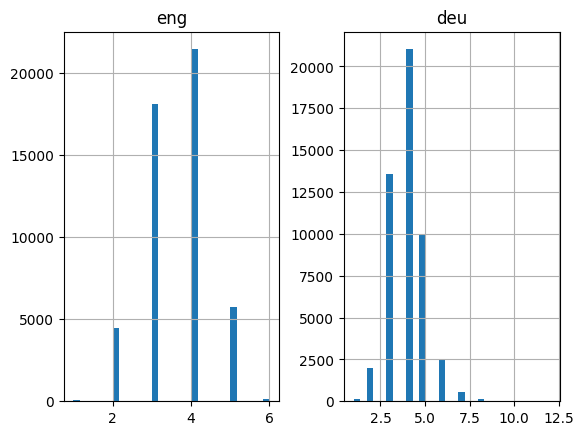

In [7]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [8]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [9]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6098


In [10]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10071


In [11]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

In [12]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [13]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [14]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [15]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
filename = 'model.h1.23_Nov_24.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint],
                    verbose=1)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 5.6951
Epoch 1: val_loss improved from inf to 3.00193, saving model to model.h1.23_Nov_24.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - loss: 5.6713 - val_loss: 3.0019
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 2.9100
Epoch 2: val_loss improved from 3.00193 to 2.81567, saving model to model.h1.23_Nov_24.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - loss: 2.9090 - val_loss: 2.8157
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 2.7318
Epoch 3: val_loss improved from 2.81567 to 2.69959, saving model to model.h1.23_Nov_24.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - loss: 2.7316 - val_loss: 2.6996
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 2.6837
Epoch 4: val_loss improved from 2.69959 to 2.67259, saving model to model.h1.23_Nov_24.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - loss: 2.6836 - val_loss: 2.6726
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 

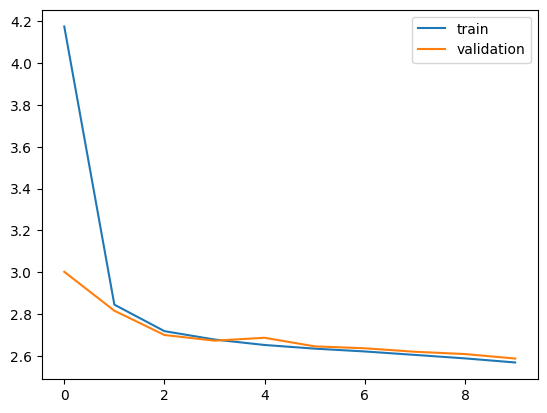

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [21]:
import numpy as np

# Load the saved model
model = load_model('model.h1.23_Nov_24.keras')

# Ensure testX is reshaped correctly
testX = testX.reshape((testX.shape[0], testX.shape[1]))

# Get predictions (probabilities)
predictions = model.predict(testX)

# Convert probabilities to class indices
preds = np.argmax(predictions, axis=-1)

print(preds)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
[[1 3 5 ... 0 0 0]
 [1 3 5 ... 0 0 0]
 [1 4 5 ... 0 0 0]
 ...
 [1 3 5 ... 0 0 0]
 [1 3 5 ... 0 0 0]
 [1 3 5 ... 0 0 0]]


In [22]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [23]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t is None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if t is None:
                temp.append('')
            else:
                temp.append(t)
    preds_text.append(' '.join(temp))

In [24]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [25]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
2442,Did you shoot Tom,tom you a
2925,Say no to drugs,tom is
294,Dont leave town,tom you a
4337,This is a fork,tom you a
1427,I wish I could help,i
5484,Is this red wine,tom is
2572,Take some aspirin,tom is
1160,Could you be quiet,tom you a
9253,Tom lost a book,tom you a
1274,Tom lost his hat,tom you a
